In [1]:
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
import faiss
from langchain_community.vectorstores import FAISS

## **Prepare vector Store and Sentence embedding**

In [2]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("data/attentation-all-you-need.pdf")
docs = loader.load()
len(docs)

15

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 80
)

documents = splitter.split_documents(documents=docs)
len(documents)

96

In [4]:
documents[5]

Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'data/attentation-all-you-need.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1'}, page_content='detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and\ntensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and\nefficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and\nimplementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating\nour research.')

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_groq import ChatGroq

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

/Users/murtazanaiyar/Desktop/Github@MN/AgenticAi/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
len(embeddings.embed_query("hello"))

768

In [7]:
index = faiss.IndexFlatIP(768)

In [8]:
from langchain_community.docstore.in_memory import InMemoryDocstore

In [ ]:
vector_store = FAISS(
 embedding_function=embeddings,
 index=index,
 docstore=InMemoryDocstore(),
 index_to_docstore_id={}
)

: 

In [ ]:
vector_store.add_documents(documents=documents)

In [ ]:
vector_store.similarity_search(query="What is autoregressive?")

In [ ]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [ ]:
retriever.invoke("What is autoregressive?")

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt.messages[0]

In [ ]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

In [ ]:
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
from IPython.display import display, Image
display(Image(rag_chain.get_graph().draw_mermaid_png()))

# ***Time to build Workstation***

In [9]:
from typing import Literal

In [10]:
class SelectPath(BaseModel):
    path: Annotated[Literal["LLM_CALL", "RAG_CALL", "INTERNET_SEARCH"], Field(description="Based on the user query select one path only. if user want to know about the Attention all you need paper or any query related to the Transformer then select the Rag call. if user want to know basics question the select llm call and finally user want to know about recent info then select the internet search.")]
    reason: Annotated[str, Field(description="Why you select a specific path give reason in one sentence.")]

In [11]:
from langchain_core.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=SelectPath)

In [12]:
path_prompt = PromptTemplate(
    template="""
    Think step by step on user query. The user query: {question}\n\n My vector store is related of Transformer paper as the paper name is *attention all you need* so if you think like user query is related to this paper then select the 'RAG_CALL'. Or user want to know about the latest news or any info the you select the 'INTERNET_SEARCH'. Finally if user want to know basics question such as wants know ML, DL, NLP, or any basics question if you think llm model can capable to give sold and correct answer then select the 'LLM_CALL'. you have to follow this format instruction.\n\n{format_instruction}.
    """,
    input_variables=["question"],
    partial_variables={
        "format_instruction": parser.get_format_instructions()
    }
)

In [13]:
path_prompt

PromptTemplate(input_variables=['question'], input_types={}, partial_variables={'format_instruction': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"path": {"description": "Based on the user query select one path only. if user want to know about the Attention all you need paper or any query related to the Transformer then select the Rag call. if user want to know basics question the select llm call and finally user want to know about recent info then select the internet search.", "enum": ["LLM_CALL", "RAG_CALL", "INTERNET_SEARCH"], "title": "Path", "type": "string"

In [14]:
test_chain = path_prompt | llm | parser

In [15]:
test_chain.invoke("What is positional embeddings?")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SelectPath(path='RAG_CALL', reason="The query about positional embeddings directly relates to the Transformer model, which was introduced in the paper 'Attention Is All You Need'.")

In [16]:
test_chain.invoke("What is the weather today in Dhaka?")

SelectPath(path='INTERNET_SEARCH', reason='The user query is about obtaining current and specific information (weather in Dhaka), which is best fulfilled by searching the internet for the latest data.')

In [17]:
response = test_chain.invoke("Why i need to learn Agentic AI?")
response.path, response.reason

('LLM_CALL',
 "The user is seeking a general understanding of why they need to learn Agentic AI, which can be addressed through a Large Language Model's knowledge base.")

## **Internet Search Pipeline Setup**

In [18]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

tavily_search = TavilySearch(
    max_results=3,
    topic="general"
)

tavily_search.invoke("Capital of bangladesh")

{'query': 'Capital of bangladesh',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What Is The Capital Of Bangladesh? - WorldAtlas',
   'url': 'https://www.worldatlas.com/articles/what-is-the-capital-of-bangladesh.html',
   'content': 'Learn about the history, geography, and culture of Dhaka, the largest and most populous city in Bangladesh. Find out how Dhaka became the capital of Bangladesh in 1971 and what makes it a unique and diverse city.',
   'score': 0.8576849,
   'raw_content': None},
  {'title': 'Dhaka - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Dhaka',
   'content': '| [1] | | Region | Southern Asia | | Notability | The Representative List of the "Intangible Cultural Heritage of Humanity" category | | | | | Dhaka (/ˈ d ɑː k ə/DAH-kə or /ˈ d æ k ə/DAK-ə; Bengali: ঢাকা, romanized:Ḍhākā, pronounced[ˈɖʱaka]ⓘ), formerly known asDacca,[20] is the capital and largest city of Bangladesh. It is one of the largest[a] and most densely po

### *Create Agent State*

In [19]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]

## **Start to build the Graph Node**

In [20]:
## Supervisor node
def supervisor(state: State):
    """This node is responsible for to select the correct path based on the user query."""
    question = state['messages'][-1]
    print(question)
    chain = path_prompt | llm | parser
    response = chain.invoke(question)
    print(response.path, response.reason)
    
    return {
        "messages": [response.path]
    }

In [21]:
state={'messages': ["What is key and value vector?"]}
supervisor(state)

What is key and value vector?
RAG_CALL The user query is related to key and value vectors, which are concepts from the Transformer paper 'Attention Is All You Need'.


{'messages': ['RAG_CALL']}

In [23]:
def router(state: State):
    print("--Router--")
    last_message = state["messages"][-1]
    print(last_message)
    
    if last_message == "RAG_CALL":
        return "RAG_CALL"
    elif last_message == "LLM_CALL":
        return "LLM_CALL"
    else:
        return "INTERNET_SEARCH"

In [24]:
from langchain_core.output_parsers import StrOutputParser

In [26]:
def llm_call(state: State):
    print("--LLM Call--")
    question = state['messages'][0]
    prompt = PromptTemplate(
        template="""
        You are a helpful ai assistant. Answer the question based on you capability. if you think you do not know about the question do not give the answer just simply say i do not know the proper answer. Though do not give any hypothetical answer or hallucination response or do not predict the answer. If you are confident enough then provide the answer properly.\n
        the user query is: {question}
        """,
        input_variables=["question"]
    )
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke(
        {
            "question": question
        }
    )
    print(response)
    return {
        "messages": [response]
    }
    

In [27]:
def internet_search(state: State):
    print("--Internet Search--")
    question = state['messages'][0]
    web_search_content = tavily_search.invoke(question)
    prompt = PromptTemplate(
        template="""
        You are a helpful ai assistant who can give answer of the user query based on the web search content. First read the user query and check the web_search_content. If you think web content is not enough for to give the answer of the user query then simply say. No have enough context to give the answer. And below the user query and web_search_content.\n\n
        the user query is: {question}\n\n
        the web_search_content: {web_search_content}\n
        """,
        input_variables=["question", "web_search_content"]
    )
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke(
        {
            "question": question,
            "web_search_content": web_search_content
        }
    )
    return {
        "messages": [response]
    }

In [28]:
from langchain import hub

In [29]:
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [31]:
def rag_call(state: State):
    print("--Rag call--")
    question = state['messages'][0]
    print(question)
    prompt = hub.pull("rlm/rag-prompt")
    
    print("im here-1")
    rag_chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | prompt
        | llm
        | StrOutputParser()
    )
    print("im hare-2")
    response = rag_chain.invoke(question)
    print("rag-response", response)
    
    return {
        "messages": [response]
    }
    

## **Validation Node**

In [32]:
class validationOutput(BaseModel):
    validation_response: Annotated[Literal["yes", "no"], Field(description="analysis the user question and the output. If you think the output is correct based on the question then say 'yes' otherwise say 'no' if the answer is not correct based on the user question.")]

In [33]:
validate_parser = PydanticOutputParser(pydantic_object=validationOutput)

In [34]:
def validation_node(state: State):
    print("---validation---")
    question = state['messages'][0]
    answer = state['messages'][-1]
    
    print(question, answer)
    validation_prompt = PromptTemplate(
        template="""Think you are evaluator, your task is validate the output of the user question. Example if the answer is correct based on the user question then simple say 'yes', otherwise say 'no' is the answer is not relevant to the question. Think very carefully to validation time. Below the user question and the answer of the question.
        the user question is : {question}\n\n and the output answer of the question is: {answer}.\n\n Most important is must be follow the output format instruction: {format_instruction}""",
        input_variables=["question", "answer"],
        partial_variables={
            "format_instruction": validate_parser.get_format_instructions()
        }
    )
    
    validation_chain = validation_prompt | llm | validate_parser
    
    result = validation_chain.invoke(
        {
            "question": question,
            "answer": answer
        }
    )
    print("im hare 3")
    print(result.validation_response)
    return {
        "messages": [result.validation_response]
    }

In [35]:
class RewriteUserQuestion(BaseModel):
    rewrite_question: Annotated[str, Field(description="Rewrite the user query for better output generation. question should be in one sentence.")]

In [36]:
rewrite_parser = PydanticOutputParser(pydantic_object=RewriteUserQuestion)

In [37]:
def rewrite_query(state: State):
    question = state['messages'][0]
    
    rewrite_prompt = PromptTemplate(
        """You are a helpful ai assistant and your task is rewrite the user input query for better response generation. Example like if user query is bad then occurred problem such as data extraction from vector store or internet search. So rewrite the query for best output generation.\n
        This is user question: {question}. and must be follow the format instruction to produce the output. The format instruction is: {format_instruction}""",
        input_variables=["question"],
        partial_variables={
            "format_instruction": rewrite_parser.get_format_instructions()
        }
    )
    
    rewrite_chain = rewrite_prompt | llm | rewrite_parser
    new_question = rewrite_chain.invoke(
        {
            "question": question
        }
    )
    state["messages"][0] = new_question.rewrite_question
    print(state["messages"][0])
    
    

In [38]:
from langgraph.graph import END

def validation_router(state: State):
    validation_result = state['messages'][-1]
    
    if validation_result == "yes":
        return "PASS"
    else:
        return "FAILED"

## Build the Graph

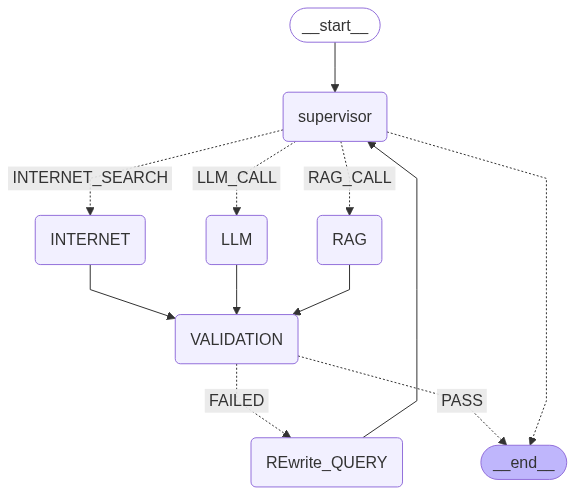

In [39]:
from langgraph.graph import START, StateGraph
from IPython.display import display, Image

workflow = StateGraph(State)

## Node
workflow.add_node("supervisor", supervisor)
workflow.add_node("LLM", llm_call)
workflow.add_node("RAG", rag_call)
workflow.add_node("INTERNET", internet_search)
workflow.add_node("VALIDATION", validation_node)
workflow.add_node("REwrite_QUERY", rewrite_query)

## Edges
workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "INTERNET_SEARCH": "INTERNET",
        "LLM_CALL": "LLM",
        "RAG_CALL": "RAG"
    }
)
workflow.add_edge("LLM", "VALIDATION")
workflow.add_edge("RAG", "VALIDATION")
workflow.add_edge("INTERNET", "VALIDATION")
workflow.add_conditional_edges(
    "VALIDATION",
    validation_router,
    {
        "PASS": END,
        "FAILED": "REwrite_QUERY"
    }
)
workflow.add_edge("REwrite_QUERY", "supervisor")

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# ***Output Testing***

In [40]:
graph.invoke(
    {
        "messages": ["What is key, query, and value vector?"]
    }
)

What is key, query, and value vector?
RAG_CALL The user query is directly related to concepts (key, query, and value vectors) discussed in the Transformer paper 'Attention Is All You Need'.
--Router--
RAG_CALL
--Rag call--
What is key, query, and value vector?
im here-1


NameError: name 'retriever' is not defined

In [ ]:
graph.invoke(
    {
        "messages": ["What is the current weather of Dhaka?"]
    }
)

In [ ]:
graph.invoke(
    {
        "messages": ["What i should learn Agentic AI?"]
    }
)